In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join
import os
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches

from scipy.optimize import curve_fit

In [2]:
fits_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data_massive/'
samp_dir = '/xdisk/timeifler/wxs0703/kl_nn/samples/samples_massive.csv'
fig_dir = '/xdisk/timeifler/wxs0703/kl_nn/figures/'

In [3]:
samples = pd.read_csv(samp_dir)

In [4]:
hdu = fits.open(join(fits_dir, 'temp_1/training_0.fits'))
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                   61                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INSTNAME= 'DESI    '                                                            
OBSTYPE =                    1                                                  
SKYMODEL= '../data/Skyspectra/spec-sky.dat'                                     
PSFTYPE = 'airy_fwhm'                                                           
PSFFWHM =                  1.0                                                  
DIAMETER=               332.42                                                  
EXPTIME =                  6

In [5]:
hdu.info()

Filename: /xdisk/timeifler/wxs0703/kl_nn/train_data_massive/temp_1/training_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 ImageHDU        24   (61,)   float64   
  2                1 ImageHDU        24   (61,)   float64   
  3                1 ImageHDU        24   (61,)   float64   
  4                1 ImageHDU        24   (61,)   float64   
  5                1 ImageHDU        24   (61,)   float64   
  6                1 ImageHDU        24   (61,)   float64   
  7                1 ImageHDU        21   (48, 48)   float32   
  8                1 ImageHDU        21   (48, 48)   float32   
  9                1 ImageHDU        21   (48, 48)   float32   
 10                1 ImageHDU        21   (48, 48)   float32   
 11                1 ImageHDU        21   (48, 48)   float32   
 12                1 ImageHDU        21   (48, 48)   float32   


In [9]:
img = hdu[7].data
noise = hdu[8].data

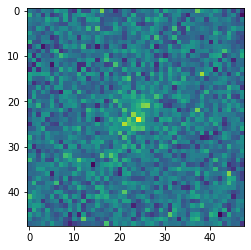

In [10]:
plt.imshow(img+noise)

In [14]:
print(noise[:5, :5])

[[  2.4091783  -4.565649  -13.433375    5.3708706   0.7823678]
 [ 28.073635   -5.4842925   7.0135183 -22.816664    5.9406257]
 [  5.015537   -1.0498098   2.6329436  -2.8273268  21.233084 ]
 [  1.1629937  -3.0654001  -6.8839817   1.209783    9.959793 ]
 [ -4.097196  -12.72677    14.814659    6.8451114 -15.172002 ]]


In [15]:
SNR = np.sum(img)/np.sum(np.abs(noise))
print(SNR)

0.10284524


In [10]:
pixscale = hdu[7].header['PIXSCALE']
fiber_offset = 1.5

In [74]:
whr = np.where((samples.iloc[:, 1] > 0.4) & (samples.iloc[:, 3] > 1.5) & \
               (samples.iloc[:, 3] < 1.6) & (samples.iloc[:, 4] < 0.1))

In [111]:
ID = 100000
folder = ID // 4000 + 1
hdu = fits.open(join(fits_dir, f'temp_{folder}/training_{ID}.fits'))
g1, g2, theta_int, sini, v0, vcirc, rscale, hlr = samples.iloc[ID, 1:]

In [112]:
ID

100000

In [113]:
cosi = np.sqrt(1-sini**2)
A = np.array([[1+g1, g2],
              [g2, 1-g1]])
R = np.array([[np.cos(theta_int), -np.sin(theta_int)],
              [np.sin(theta_int), np.cos(theta_int)]])
P = np.array([[1, 0],
              [0, cosi]])
T = np.matmul(A, np.matmul(R, P))

In [114]:
U, S, Vh = np.linalg.svd(T)
offsets = [(fiber_offset*np.cos(0),         fiber_offset*np.sin(0)),
           (fiber_offset*np.cos(np.pi),   fiber_offset*np.sin(np.pi)),
           (0,0)]
offsets = np.matmul(offsets, U)

In [117]:
for (dx, dy) in offsets:
    print(dx, dy)

0.14354899161992107 1.493115429899813
-0.14354899161992088 -1.493115429899813
0.0 0.0


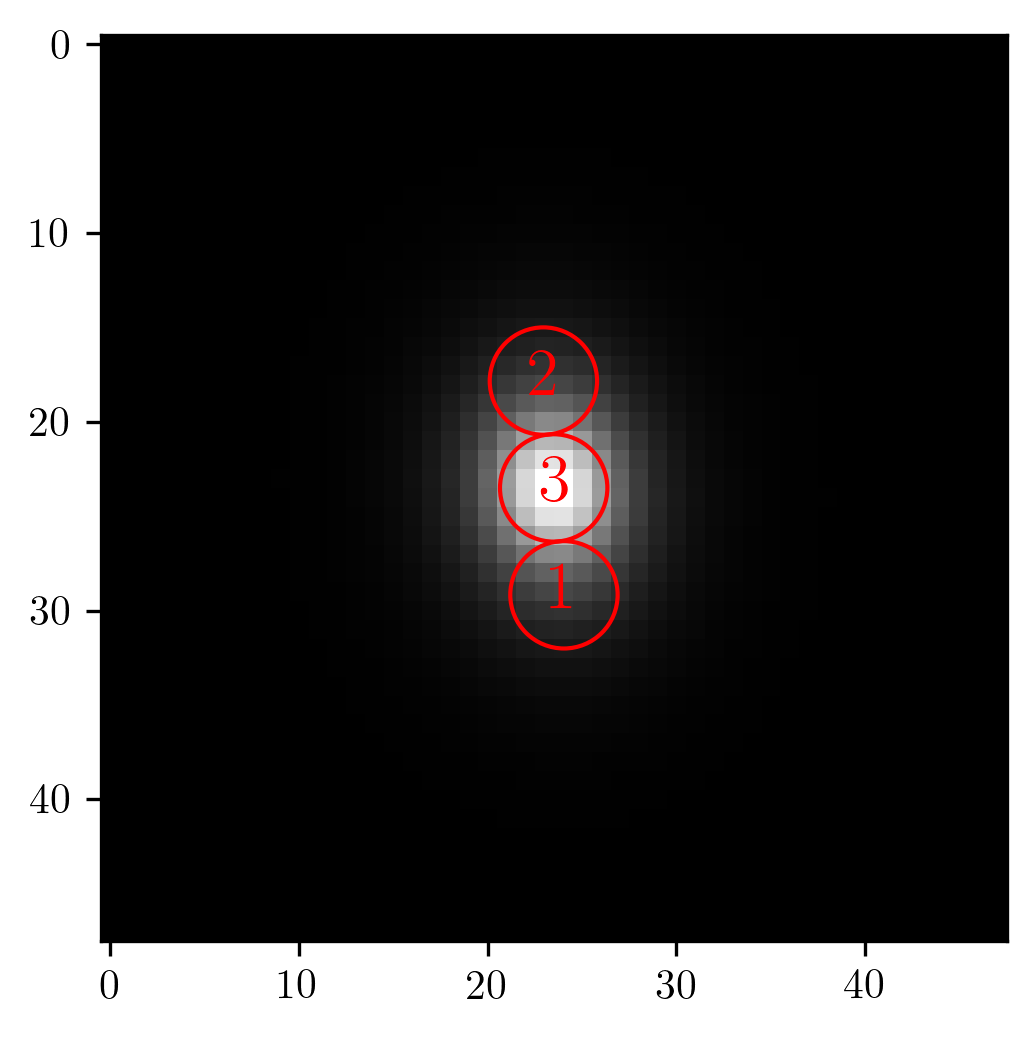

In [116]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 300})
ax = plt.figure().add_subplot()
image_data = hdu[11].data
ax.imshow(image_data, cmap='gray')

for j in range(3):
    x, y = offsets[j]
    x = x/pixscale + 23.5
    y = y/pixscale + 23.5
    offsetpos = (x,y)
    fiber = patches.Circle(offsetpos, 0.75/pixscale, color='red', fill=False)
    ax.add_patch(fiber)
    ax.text(x-0.75, y+0.75, f'{j+1}', fontsize=16, color='red')

plt.show()

In [5]:
hi_vcirc_whr = np.where(samples.iloc[:, 6] > 300)
samples_hi_vcirc = samples.iloc[hi_vcirc_whr]

In [27]:
hi_vcirc_whr

(array([     2,      3,      6, ..., 999995, 999996, 999997]),)

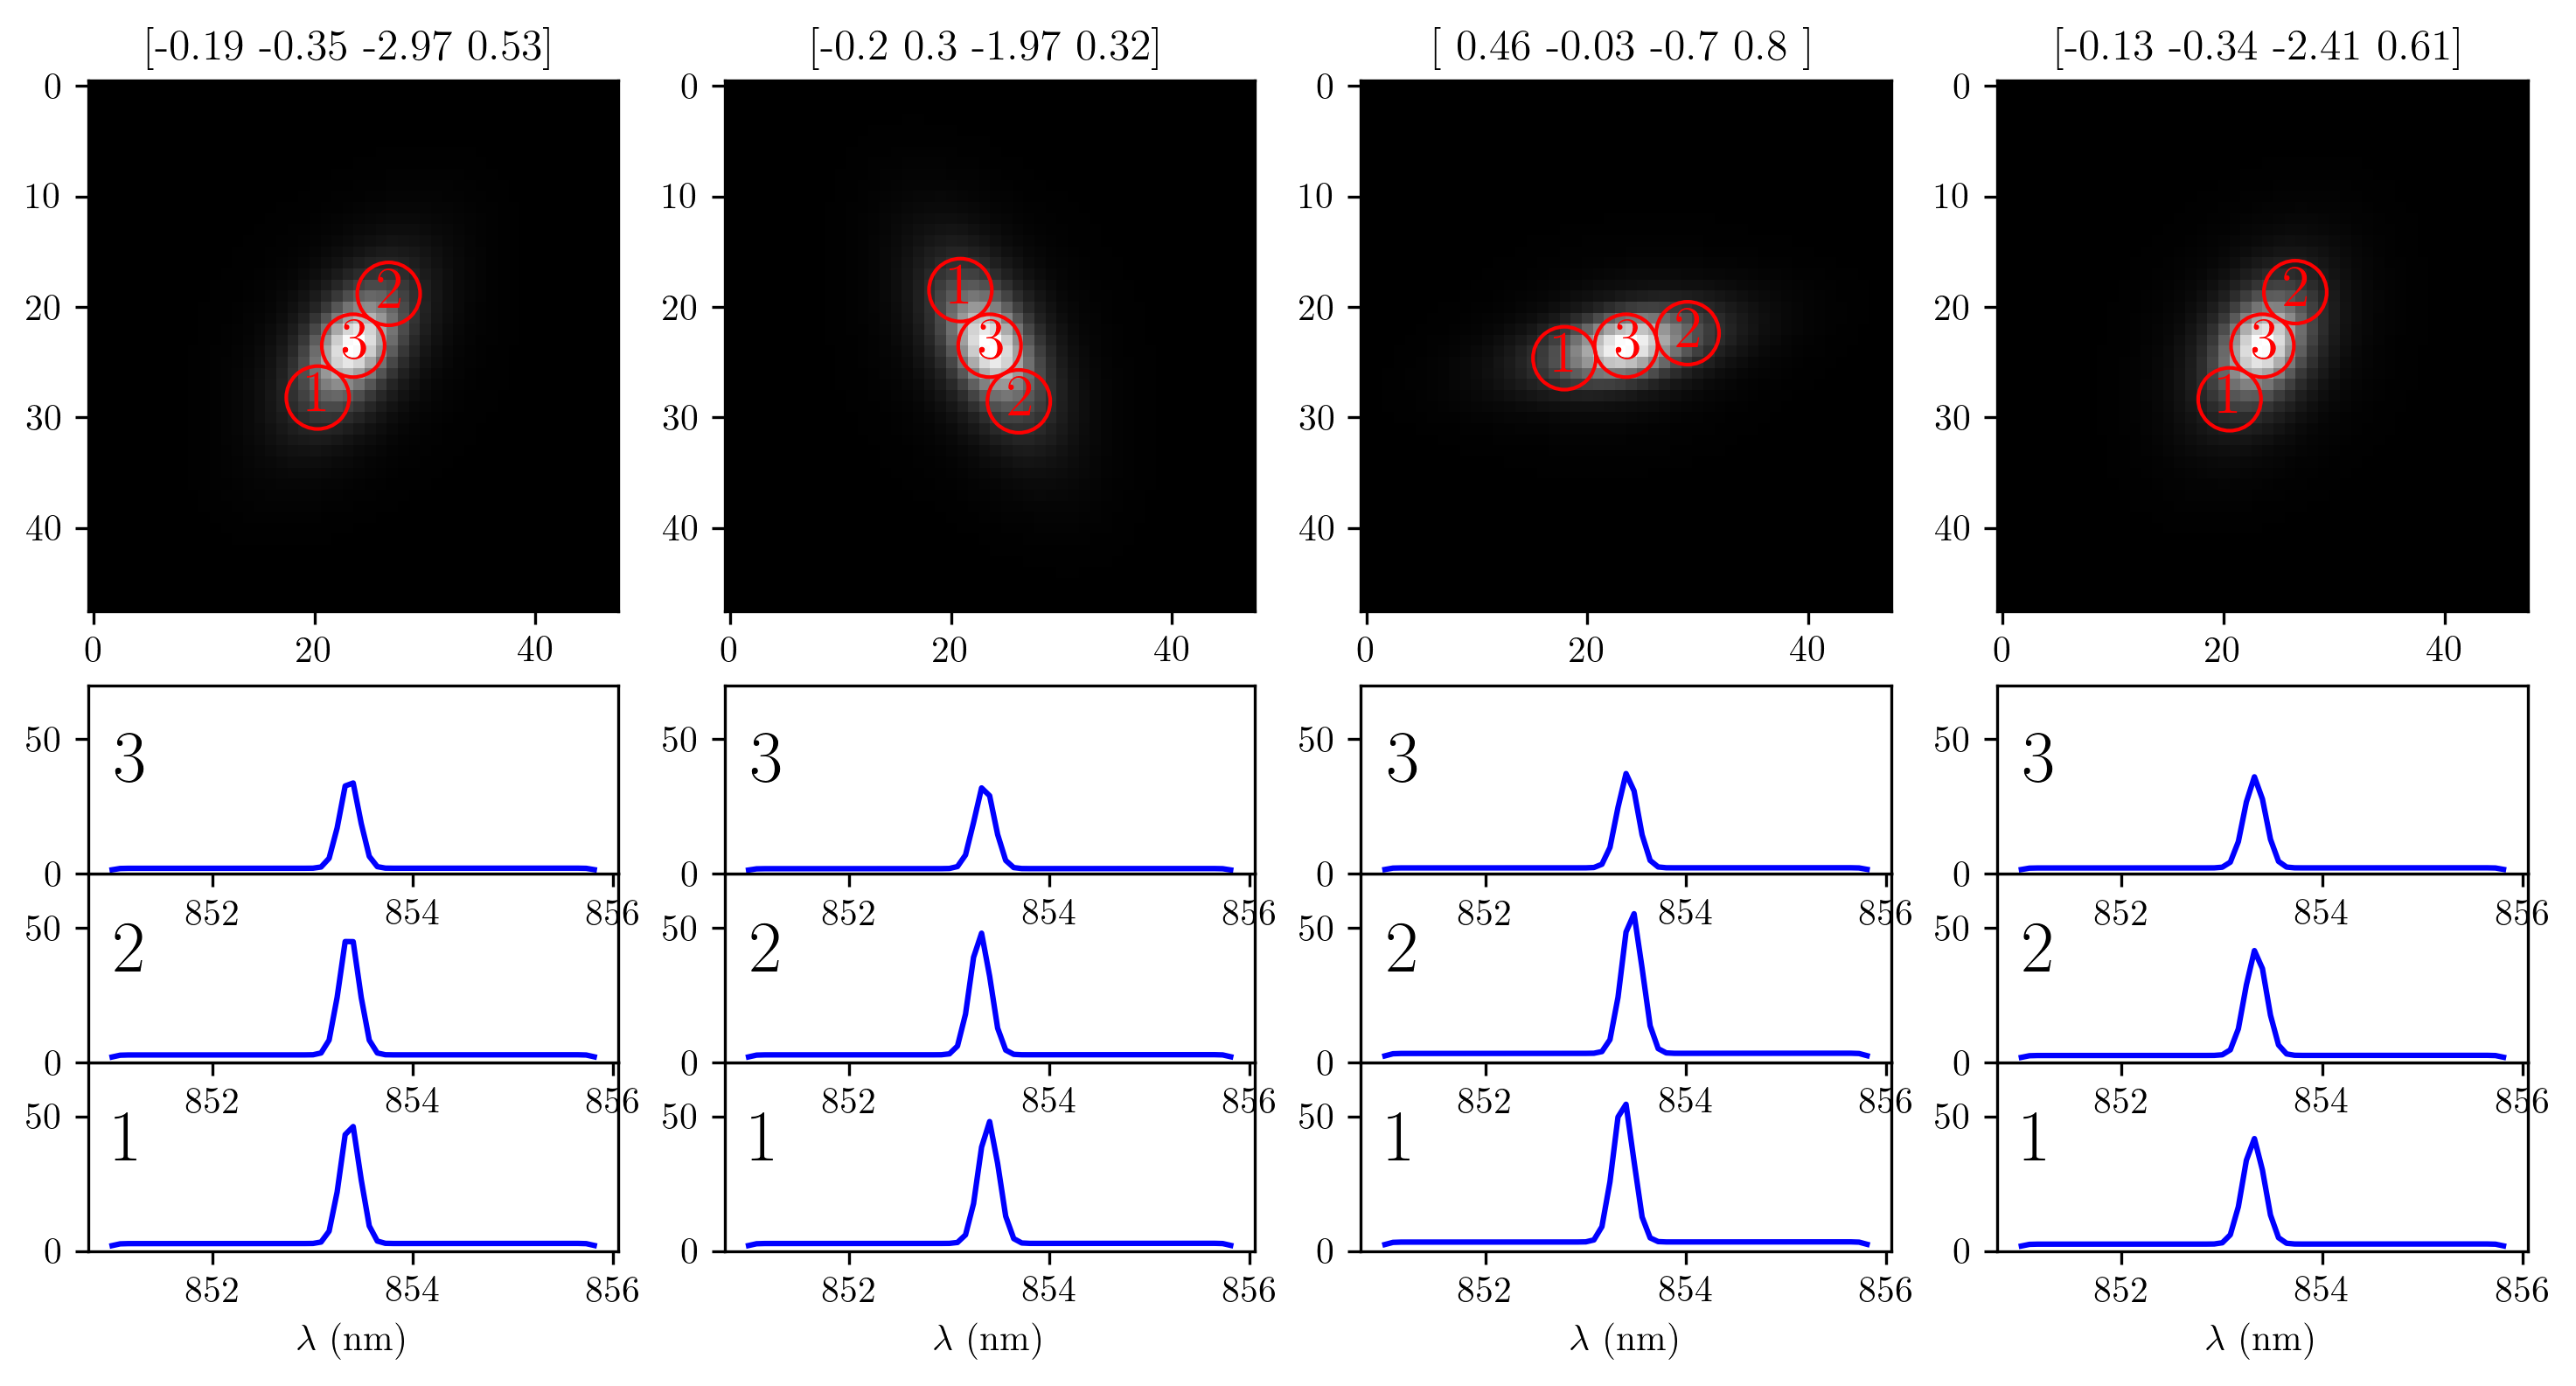

In [11]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 4, wspace=0.2, hspace=0.1)
lamb = np.linspace(851, 855.81, 61)


for i, grid in enumerate(gs):
    if i < 4:
        ax = plt.subplot(grid)
        hdu = fits.open(join(fits_dir, f'temp_1/training_{i}.fits'))
        params = np.round(np.array(samples.iloc[i]), 2)
        image_data = hdu[11].data
        ax.imshow(image_data, cmap='gray')
        
        for j in range(3):
            x, y = hdu[j*2+1].header['FIBERDX'], hdu[j*2+1].header['FIBERDY']
            x = x/pixscale + 23.5
            y = y/pixscale + 23.5
            offsetpos = (x,y)
            fiber = patches.Circle(offsetpos, 0.75/pixscale, color='red', fill=False)
            ax.add_patch(fiber)
            ax.text(x-1, y+1.25, f'{j+1}', fontsize=16, color='red')
        ax.set_title(f'{params[1:5]}')
        
    else:
        i -= 4
        hdu = fits.open(join(fits_dir, f'temp_1/training_{i}.fits'))
        spec_data = hdu[1].data
        ax = plt.subplot(grid)
        plt.sca(ax)
        ax.plot(lamb, spec_data, color='blue')
        ax.text(0.05, 0.75, '1', horizontalalignment='left', verticalalignment='top', transform = ax.transAxes, fontsize=20)
        ax.set_ylim(0, 70)
        ax.set_xlabel(r'$\lambda$ (nm)')
        divider = make_axes_locatable(ax)

        for j in range(2):
            index = 2*(j+1)+1
            spec_data = hdu[index].data
            ax1 = divider.append_axes("top", size="100%", pad=0, sharex=ax)
            ax1.plot(lamb, spec_data, color='blue')
            ax1.text(0.05, 0.75, f'{j+2}', horizontalalignment='left', verticalalignment='top', transform = ax1.transAxes, fontsize=20)
            #ax1.set_xticklabels([])
            ax1.set_ylim(0, 70)

plt.savefig(join(fig_dir, 'training_data_img_samples.jpg'), dpi=300)
plt.show()

In [14]:
print(lamb)

[851.         851.08016667 851.16033333 851.2405     851.32066667
 851.40083333 851.481      851.56116667 851.64133333 851.7215
 851.80166667 851.88183333 851.962      852.04216667 852.12233333
 852.2025     852.28266667 852.36283333 852.443      852.52316667
 852.60333333 852.6835     852.76366667 852.84383333 852.924
 853.00416667 853.08433333 853.1645     853.24466667 853.32483333
 853.405      853.48516667 853.56533333 853.6455     853.72566667
 853.80583333 853.886      853.96616667 854.04633333 854.1265
 854.20666667 854.28683333 854.367      854.44716667 854.52733333
 854.6075     854.68766667 854.76783333 854.848      854.92816667
 855.00833333 855.0885     855.16866667 855.24883333 855.329
 855.40916667 855.48933333 855.5695     855.64966667 855.72983333
 855.81      ]


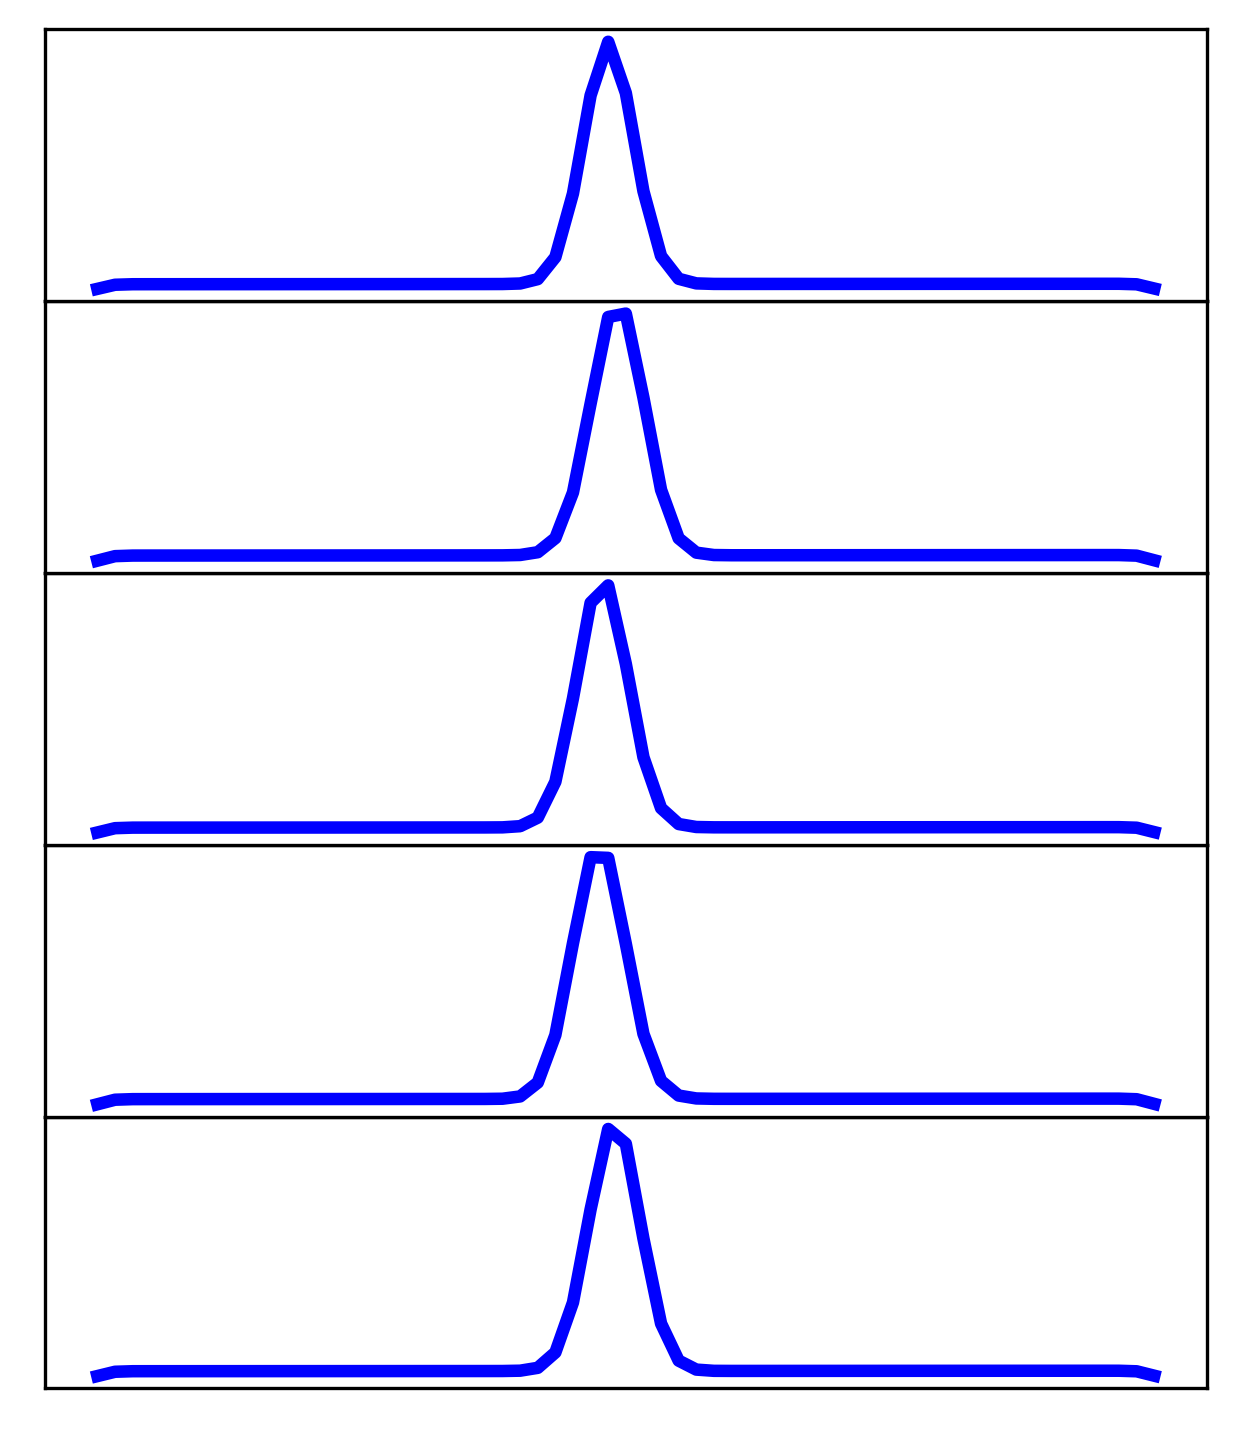

In [17]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 300})
fig, ax = plt.subplots(figsize=(5, 6))

hdu = fits.open(join(fits_dir, 'training_0.fits'))
spec_data = hdu[1].data
plt.sca(ax)
ax.plot(spec_data, color='blue', lw=3)
divider = make_axes_locatable(ax)
# set visibility of x-axis as False
xax = ax.axes.get_xaxis()
xax = xax.set_visible(False)
 
# set visibility of y-axis as False
yax = ax.axes.get_yaxis()
yax = yax.set_visible(False)

for j in range(4):
    index = 2*(j+1)+1
    spec_data = hdu[index].data
    ax1 = divider.append_axes("top", size="100%", pad=0, sharex=ax)
    ax1.plot(spec_data, color='blue', lw=3)
    ax1.set_xticklabels([])
    # set visibility of x-axis as False
    xax = ax1.axes.get_xaxis()
    xax = xax.set_visible(False)

    # set visibility of y-axis as False
    yax = ax1.axes.get_yaxis()
    yax = yax.set_visible(False)

plt.savefig(join(fig_dir, 'spectra_example.jpg'), dpi=300)